# Instrucciones Parte Computacional
## Tarea 4 ICS 3153 - Optimización Avanzada

En la pregunta 3 de su tarea se plantea el problema de optimización $\ell^1$ para la reconstrucción sparse


$$
(P)\quad \min \left\{f(x)=\|x\|_{1} : A x=b\right\}
$$

Recordemos que este problema está motivado por la detección de un vector sparse $x^* \in \mathbb{R}^d$ a través de observaciones lineales $b = Ax^∗$, en el contexto de _compressed sensing_, una técnica de procesamiento de señales para adquirir y reconstruir una señal de manera eficiente mediante la búsqueda de soluciones para sistemas lineales indeterminados. 


Generalmente las señales no son sparse pero sí pueden ser representadas de manera sparse si se escoge una base adecuada. Por ejemplo considere la señal original "y" junto con su transformada de fourier "y_t" en el dominio de frecuencias

![title](img/1dsignal.png)

Claramente la tranformada es de una forma mas "simple" que la señal original



## Datos

Vamos a reconstruir una señal 2D. Nuestra objeto o modelo original consistirán en las siguiente imégenes

![title](data/mandrill.jpg)
![title](data/peppers.jpg)
![title](data/Lena.jpg)
![title](data/camera.jpg)


[Más Información][1] sobre las imágenes

[1]:http://www.computableminds.com/post/lena-soderberg-common-image-processing-test-images.html



Esta imagen representada como una matriz de píxeles claramente no es _sparse_, sin embargo si la representamos en el espacio de frecuencias los supuestos si se cumplen. 

Las imágenes se encuentran en la carpeta "data"

### Librerías

Partimos por importar algunas librerías

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import scipy.ndimage as spimg

### Lectura de los datos

A continuación leemos una de la imágenes y la comprimimos para hacer mas rápido los cómputos

In [2]:
# read original image and downsize for speed
Xorig = spimg.imread('data/mandrill.jpg', flatten=True, mode='L') 
X = spimg.zoom(Xorig, 0.4) 
ny,nx = X.shape
nx,ny

C:\Users\Alberto\Documents\Ana\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


(80, 80)

## Visualización de la señal completa


para ver las imágenes puede usar la siguiente función de matplotlib

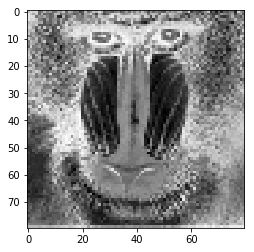

In [3]:
plt.imshow(X,'Greys')
plt.show()

## Vector "b" de observaciones

Ahora vamos a tomar una muestra pequeña de la señal original (esta muestra será nuestro vector $b$). Para generarlo sampleamos aleatoriamente elementos de la matriz. El método .flat vectoriza la matrix

In [4]:

k = round(nx * ny * 0.2) # 20% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
b = np.expand_dims(b, axis=1)


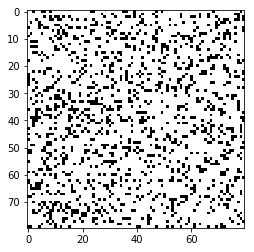

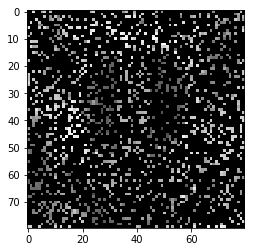

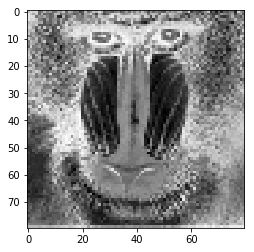

In [5]:
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]


# Matriz de muestreo
plt.imshow(mask,'Greys')
plt.show()

# Señal muestreada
plt.imshow(Xm,'Greys')
plt.show()

# Señal original
plt.imshow(X,'Greys')
plt.show()


## La matriz "A"

A continuación contruimos la matriz A. La idea del método a grandes rasgos es el siguiente:

Queremos derivar una matriz $A$ que se puede multiplicar con una solución candidata $x$ para obtener $b$, un vector que contiene muestras de una señal $f$ original. 

Comenzamos escribiendo $f$, la señal objetivo, en forma vectorial (es decir, si la señal es bidimensional o superior, la aplastamos). Sea $\Phi$ una matriz de muestreo. Entonces definimos

$$b =\Phi f$$

Ahora sea $\Psi$ la matriz que transforma una señal del dominio espectral al dominio temporal (la inversa de la transformada de Fourier discreta). Dada una solución $x$ en el dominio de frecuencias, se deduce que:

$$\Psi x = f$$

Combinando ambas ecuaciones se obtiene:

$$Ax = b$$ donde  $$A\equiv \Phi \Psi $$

La matriz es fácil de construir: es la transformada de coseno discreta inversa que actúa sobre las columnas de la matriz de identidad.


In [6]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

## Recuperación de la señal original a partir de la señal muestreada


Para este último punto usted debe implementar un solver para recuperar la imagen original a partir de el muestreo $b$ y la matriz $A$. 

Si quiere pude comparar su solver con uno de python. Para esto puede por ejemplo utilizar la librería "cvxpy". Para instalarla en una terminal escribir:

    pip install cvxpy
    
Nota: para valores muy grandes de nx y ny cvxpy podría ser muy lento

In [7]:
import cvxpy as cvx


b = b.flatten()
# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 12800, constraints m = 14080
          nnz(P) + nnz(A) = 8217600
settings: linear system solver = qdldl,
          eps_abs = 1.0e-04, eps_rel = 1.0e-04,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -5.1200e+04   2.01e+02   3.28e+08   1.00e-01   1.10e+01s
 200   5.4326e+04   3.32e+01   3.46e-02   1.31e-03   2.19e+01s
 400   5.4926e+04   4.90e+00   9.64e-04   2.08e-04   2

## Recuperar la imagen a partir del "x" candidato   

In [8]:
Xat2 = np.array(vx.value).squeeze()
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)



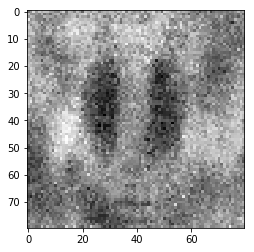

In [9]:
plt.imshow(Xa, 'Greys')
plt.show()

In [7]:
#Ahora se pasaremos al desarrollo de la tarea

In [ ]:
#--------------------------------------------------------

In [ ]:
#------- Parte I ----------------------------------------

In [8]:
#IMPLEMENTACION PERSONAL

#Instalacion de librerias a utilizar

import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import linalg as LA
from numpy.linalg import inv
import time

In [9]:
#Función de proyeccción

def proyeccion_sobre_C(A,b,x):
    z=x-np.dot(A.T,np.dot(np.linalg.inv(np.dot(A,A.T)),(np.dot(A,x)-b)))
    return z

In [10]:
#Gradiente de F_lambda

def gradiente_f_lambda(x, lam):
    n=len(x)
    u=[]
    for i in range(n):
        z=float(x[i])
        z1=abs(z)
        if z1>=lam:
            w=[]
            w.append(np.sign(float(x[i])))
            u.append(w)
        else:
            w=[]
            w.append(z/lam)
            u.append(w)
    u=np.array(u)
    return u

In [11]:
#Programacion del gradiente proyectado

def gradiente_proyectado(A,b,T,lam):
    lista=[]
    lista2=[]
    #Agregamos un x_0
    m=len(A[0])
    x_0=[]
    for i in range(m):
        x_0.append([0])
    x_0=np.array(x_0)
    x=x_0
    lista2.append(x)
    #Lo proyectamos el x_0
    x=proyeccion_sobre_C(A,b,x)
    lista.append(LA.norm(x,1))
    for j in range(T):
        x=x-lam*gradiente_f_lambda(x,lam)
        x=proyeccion_sobre_C(A,b,x)
        lista.append(LA.norm(x,1))
        lista2.append(x)
    lista_final=[]
    lista_final.append(lista)
    lista_final.append(lista2)
    return lista_final

In [12]:
#Programacion del gradiente a utilizar en Nesterov

def gradiente_Nesterov(x, A, b, lam, mu):
    z = gradiente_f_lambda(x, lam) + mu*np.dot(A.T,(np.dot(A,x)-b))
    return z

In [13]:
#Método de Nesterov

def Nesterov(A, b, lam, mu, T):
    lista=[]
    lista2=[]
    #Calculamos el x_0
    m=len(A[0])
    x_0=[]
    for i in range(m):
        x_0.append([0])
    x_0=np.array(x_0)
    x=x_0
    y=x
    #Calculamos el eta
    eta=((1/lam)+mu)**(-1)
    lista.append(LA.norm(y,1))
    lista2.append(y)
    for j in range(T):
        v=x
        x=y-eta*gradiente_Nesterov(y, A, b, lam, mu)
        y=x+(j/(j+3))*(x-v)
        lista.append(LA.norm(y,1))
        lista2.append(y)
    lista_final=[]
    lista_final.append(lista)
    lista_final.append(lista2)
    return lista_final

In [14]:
#Ahora graficaremos el gradiente proyectado para diferentes lambdas

#Distintos lambdas

l1=0.1
l2=0.01
l3=0.001

#Numero de iteraciones

T=100

#Ejecutamos gradiente proyectado para los distintos lambda

w1=gradiente_proyectado(A,b,T,l1)[0]
w2=gradiente_proyectado(A,b,T,l2)[0]
w3=gradiente_proyectado(A,b,T,l3)[0]

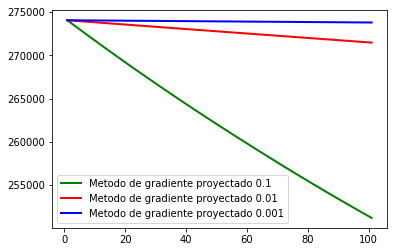

In [15]:
#GRAFICO EN ESCALA NORMAL DE LOS DIFERENTES LAMBDAS

#Ahora calculamos el eje de los X para graficar

u=[]
for k in range(len(w1)):
    u.append(k+1)

#Ahora graficamos gradiente proyectado para todos los lambda con escala normal

plt.plot(u,w1,color="green", linewidth=2, label='Metodo de gradiente proyectado 0.1')
plt.plot(u,w2,color="red", linewidth=2, label='Metodo de gradiente proyectado 0.01')
plt.plot(u,w3,color="blue", linewidth=2, label='Metodo de gradiente proyectado 0.001')

plt.legend(loc='best')
plt.show()

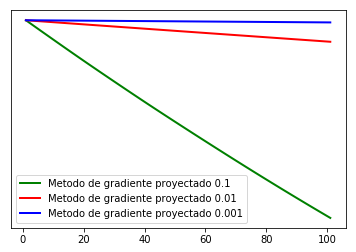

In [16]:
#GRAFICO EN ESCALA LOGARITMICA DE LOS DIFERENTES LAMBDAS

#Ahora calculamos el eje de los X para graficar

u=[]
for k in range(len(w1)):
    u.append(k+1)

#Ahora graficamos gradiente proyectado para todos los lambda con escala normal

plt.plot(u,w1,color="green", linewidth=2, label='Metodo de gradiente proyectado 0.1')
plt.plot(u,w2,color="red", linewidth=2, label='Metodo de gradiente proyectado 0.01')
plt.plot(u,w3,color="blue", linewidth=2, label='Metodo de gradiente proyectado 0.001')

plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [17]:
# Notemos que los algoritmos para lambda = 0.01 y 0.001 son muchos más similares que los algoritmos para lambda = 0.1 y 0.01. 
# Como queremos elegir un lambda muy pequeño pues el limite tiende a la función, entonces elegimos a 0.001. Aunque ojo
# el lambda también nos dará el paso entonces hay un tradeoff entre el lambda que elegiremos respecto a similitud y tamaño del
# lambda

In [18]:
# Lambda y numero de iteraciones

lam=0.001
T=100

# Ejecutaremos el metodo de nesterov con 3 distintos mu's

mu1=10**2
mu2=10**3
mu3=10**4

# Ejecutaamos los algoritmos para distintos mu's

l1=Nesterov(A, b, lam, mu1, T)[0]
l2=Nesterov(A, b, lam, mu2, T)[0]
l3=Nesterov(A, b, lam, mu3, T)[0]

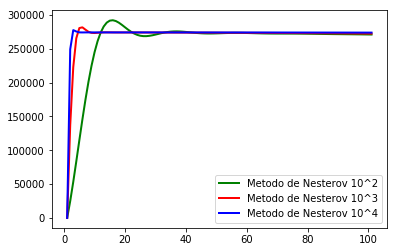

In [19]:
#GRAFICO EN ESCALA NORMAL DE LOS DIFERENTES MUS

#Ahora calculamos el eje de los X para graficar

u=[]
for k in range(len(l1)):
    u.append(k+1)

#Ahora graficamos gradiente proyectado para todos los lambda con escala normal

plt.plot(u,l1,color="green", linewidth=2, label='Metodo de Nesterov 10^2')
plt.plot(u,l2,color="red", linewidth=2, label='Metodo de Nesterov 10^3')
plt.plot(u,l3,color="blue", linewidth=2, label='Metodo de Nesterov 10^4')

plt.legend(loc='best')
plt.show()

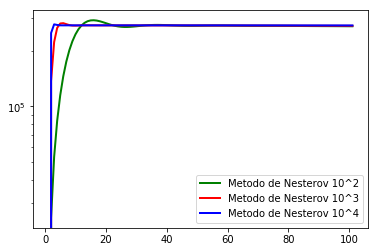

In [20]:
#GRAFICO EN ESCALA LOGARITMICA DE LOS DIFERENTES MUS

#Ahora calculamos el eje de los X para graficar

u=[]
for k in range(len(l1)):
    u.append(k+1)

#Ahora graficamos gradiente proyectado para todos los lambda con escala normal

plt.plot(u,l1,color="green", linewidth=2, label='Metodo de Nesterov 10^2')
plt.plot(u,l2,color="red", linewidth=2, label='Metodo de Nesterov 10^3')
plt.plot(u,l3,color="blue", linewidth=2, label='Metodo de Nesterov 10^4')

plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [21]:
# Se observa que para mu=10^3 y 10^4 se comportan muy parecidos los algoritmos así que elegiremos mu=10^3 y ahora la 
# comparacion entre ambos métodos las haremos para mu=10^3 y lambda = 10^(-3)

In [22]:
# Nesterov y gradiente proyectado

# Numero de iteraciones

T=100

# Lambda y mu a utilizar

lambdao=10**(-3)
mu=10**(3)

p1=gradiente_proyectado(A,b,T,lambdao)[0]
p2=Nesterov(A, b, lambdao, mu, T)[0]

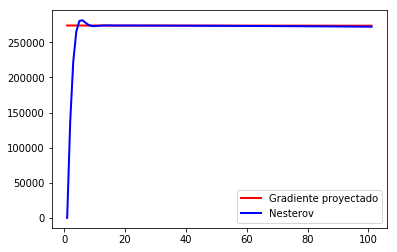

In [23]:
# GRAFICO DE GRADIENTE PROYECTADO VS NESTEROV EN ESCALA NORMAL

# Eje de los X

u=[]
for k in range(len(p1)):
    u.append(k+1)

plt.plot(u,p1,color="red", linewidth=2, label='Gradiente proyectado')
plt.plot(u,p2,color="blue", linewidth=2, label='Nesterov')

plt.legend(loc='best')
plt.show()

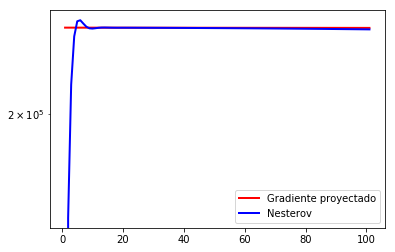

In [24]:
# GRAFICO DE GRADIENTE PROYECTADO VS NESTEROV EN ESCALA LOGARITMICA

plt.plot(u,p1,color="red", linewidth=2, label='Gradiente proyectado')
plt.plot(u,p2,color="blue", linewidth=2, label='Nesterov')

plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [25]:
#------- Parte II ----------------------------------------

In [26]:
# Implementaremos un método propuesto por nosotros que basicamente itera 10 veces segun nesterov, luego una segun gradiente
# proyectado y luego 10 más según nesterov para aprovechar la velocidad del algoritmo

In [28]:
# Pero antes implementaremos un procesamiento para así obtener una solución sparse con nuestro método

In [29]:
def procesamiento(x, valor):
    y=[]
    for i in range(len(x)):
        if abs(float(x[i]))<valor:
            y.append([0])
        else:
            y.append(x[i])
    y=np.array(y)
    return y 

In [30]:
def norma_0(x):
    sum=0
    for i in range(len(x)):
        if float(x[i])!=0:
            sum=sum+1
    return sum

In [31]:
def combinacion(A, b, lam, mu, T, valor):
    lista=[]
    lista2=[]
    #Calculamos el x_0
    m=len(A[0])
    x_0=[]
    for i in range(m):
        x_0.append([0])
    x_0=np.array(x_0)
    x=x_0
    y=x
    #Calculamos el eta
    eta=((1/lam)+mu)**(-1)
    lista.append(LA.norm(y,1))
    lista2.append(y)
    o=int(T/10)
    for i in range(o):
        for j in range(9):
            v=x
            x=y-eta*gradiente_Nesterov(y, A, b, lam, mu)
            y=x+(j/(j+3))*(x-v)
            y=procesamiento(y, valor)
            lista.append(LA.norm(y,1))
            lista2.append(y)
        x=proyeccion_sobre_C(A,b,x)
        y=proyeccion_sobre_C(A,b,y)
        lista2.append(y)
    lista_final=[]
    lista_final.append(lista)
    lista_final.append(lista2)
    return lista_final

In [32]:
#Grafico del nuevo metodo

mu=10**(3)
lam=10**(-3)
T=100
valor=1

# Ejecutar los comandos

Y=combinacion(A, b, lam, mu, T, valor)

In [33]:
Y1=Y[0]

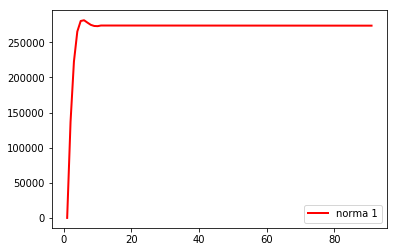

In [34]:
u=[]
for k in range(len(Y1)):
    u.append(k+1)

plt.plot(u,Y1,color="red", linewidth=2, label='norma 1')

plt.legend(loc='best')
plt.show()

In [35]:
#Diremos que el x_o que es el x optimo lo obtenemos por Nesterov

In [36]:
p1=Nesterov(A, b, lambdao, mu, T)[1]
x_o=p1[len(p1)-1]

In [40]:
#Ahora calcularemos el x que nos da nuestro algoritmo que implementamos nosotros

T=100

# Lambda y mu a utilizar

lambdao=10**(-3)
mu=10**(3)
valor=1

In [41]:
#Ahora lo que haremos será graficar la deteccion de soporte y el error de reconstruccion

In [42]:
C1=combinacion(A, b, lam, mu, T, valor)[1]

In [43]:
u=[]
Y1=[]
Y2=[]
valor=1

for k in range(len(C1)):
    u.append(k+1)
    Y1.append(norma_0(procesamiento(C1[k]-x_o,valor)))
    Y2.append(LA.norm(C1[k]-x_o))

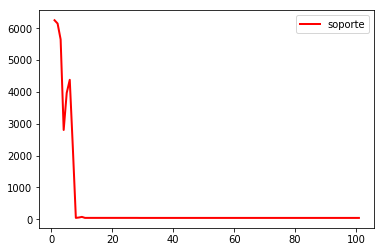

In [44]:
plt.plot(u,Y1,color="red", linewidth=2, label='soporte')

plt.legend(loc='best')
plt.show()

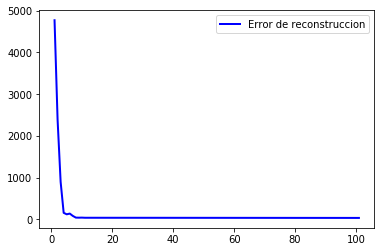

In [45]:
plt.plot(u,Y2,color="blue", linewidth=2, label='Error de reconstruccion')

plt.legend(loc='best')
plt.show()

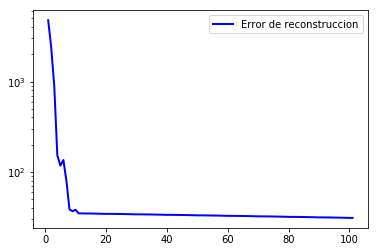

In [46]:
plt.plot(u,Y2,color="blue", linewidth=2, label='Error de reconstruccion')

plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [47]:
# Por lo que observamos el método converge en 15 iteraciones aprox, por lo tanto veremos cuanto tiempo se demora en iterar
# 15 iteraciones nuestro algoritmo

In [51]:
t1=time.perf_counter()
combinacion(A, b, lam, mu, 15, valor)[1]
t2=time.perf_counter()

print(t2-t1)

1.5780190890000085
